In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_BN(conv_num=1):
    init_channel = 64
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel*(2**int((i+1)/3))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(BatchNormalization())
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 1024000)           4096000   
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 20,480,656
Trainable params: 18,432,528
Non-trainable pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_44 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8639 - acc: 0.4998
Epoch 00001: val_loss improved from inf to 1.61969, saving model to model/checkpoint/1D_CNN_custom_3_BN_4_conv_checkpoint/001-1.6197.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 1.8642 - acc: 0.4997 - val_loss: 1.6197 - val_acc: 0.5229
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8715 - acc: 0.7499
Epoch 00002: val_loss improved from 1.61969 to 1.36392, saving model to model/checkpoint/1D_CNN_custom_3_BN_4_conv_checkpoint/002-1.3639.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.8715 - acc: 0.7498 - val_loss: 1.3639 - val_acc: 0.6410
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4380 - acc: 0.8737
Epoch 00003: val_loss did not improve from 1.36392
36805/36805 [===============

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0522 - acc: 0.9888
Epoch 00029: val_loss did not improve from 1.36392
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0522 - acc: 0.9888 - val_loss: 2.5319 - val_acc: 0.6252
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9957
Epoch 00030: val_loss did not improve from 1.36392
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0289 - acc: 0.9957 - val_loss: 2.4202 - val_acc: 0.6508
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9939
Epoch 00031: val_loss did not improve from 1.36392
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0371 - acc: 0.9939 - val_loss: 2.9780 - val_acc: 0.5819
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0384 - acc: 0.9926
Epoch 00032: val_loss did not improve from 1.36392
36805/36805 [===========

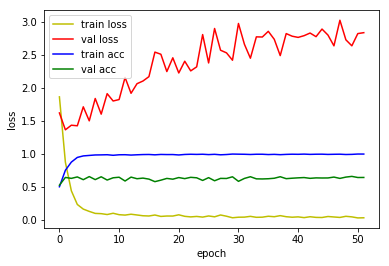

4815/4815 [==============================] - 4s 929us/sample - loss: 1.4429 - acc: 0.6108
Loss: 1.4428655887813706 Accuracy: 0.6107996

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6780 - acc: 0.5036
Epoch 00001: val_loss improved from inf to 1.50669, saving model to model/checkpoint/1D_CNN_custom_3_BN_5_conv_checkpoint/001-1.5067.hdf5
36805/36805 [==============================] - 97s 3ms/sample - loss: 1.6781 - acc: 0.5036 - val_loss: 1.5067 - val_acc: 0.5288
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0418 - acc: 0.6892
Epoch 00002: val_loss improved from 1.50669 to 1.20731, saving model to model/checkpoint/1D_CNN_custom_3_BN_5_conv_checkpoint/002-1.2073.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 1.0419 - acc: 0.6891 - val_loss: 1.2073 - val_acc: 0.6408
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7980 - acc

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0421 - acc: 0.9912
Epoch 00029: val_loss did not improve from 0.97113
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0422 - acc: 0.9912 - val_loss: 1.3711 - val_acc: 0.7170
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9939
Epoch 00030: val_loss did not improve from 0.97113
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0318 - acc: 0.9939 - val_loss: 1.3030 - val_acc: 0.7410
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0347 - acc: 0.9927
Epoch 00031: val_loss did not improve from 0.97113
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0347 - acc: 0.9927 - val_loss: 1.4465 - val_acc: 0.7102
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9944
Epoch 00032: val_loss did not improve from 0.97113
36805/36805 [===========


1D_CNN_custom_3_BN_5_conv Model


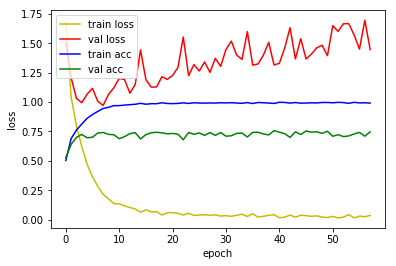

4815/4815 [==============================] - 5s 979us/sample - loss: 1.0920 - acc: 0.7007
Loss: 1.0920349958158357 Accuracy: 0.70072687

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6809 - acc: 0.4862
Epoch 00001: val_loss improved from inf to 1.41706, saving model to model/checkpoint/1D_CNN_custom_3_BN_6_conv_checkpoint/001-1.4171.hdf5
36805/36805 [==============================] - 101s 3ms/sample - loss: 1.6808 - acc: 0.4862 - val_loss: 1.4171 - val_acc: 0.5316
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0358 - acc: 0.6897
Epoch 00002: val_loss improved from 1.41706 to 0.99197, saving model to model/checkpoint/1D_CNN_custom_3_BN_6_conv_checkpoint/002-0.9920.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 1.0358 - acc: 0.6897 - val_loss: 0.9920 - val_acc: 0.7095
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8235 - a

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0597 - acc: 0.9878
Epoch 00028: val_loss did not improve from 0.57161
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0598 - acc: 0.9878 - val_loss: 0.7107 - val_acc: 0.8295
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0651 - acc: 0.9856
Epoch 00029: val_loss improved from 0.57161 to 0.53848, saving model to model/checkpoint/1D_CNN_custom_3_BN_6_conv_checkpoint/029-0.5385.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 0.0651 - acc: 0.9856 - val_loss: 0.5385 - val_acc: 0.8647
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9932
Epoch 00030: val_loss did not improve from 0.53848
36805/36805 [==============================] - 94s 3ms/sample - loss: 0.0398 - acc: 0.9932 - val_loss: 0.6666 - val_acc: 0.8374
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.062

36800/36805 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9908
Epoch 00057: val_loss did not improve from 0.53848
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0398 - acc: 0.9907 - val_loss: 0.7794 - val_acc: 0.8425
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9964
Epoch 00058: val_loss did not improve from 0.53848
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0213 - acc: 0.9964 - val_loss: 0.6161 - val_acc: 0.8689
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9964
Epoch 00059: val_loss did not improve from 0.53848
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0208 - acc: 0.9964 - val_loss: 0.7320 - val_acc: 0.8581
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0384 - acc: 0.9904
Epoch 00060: val_loss did not improve from 0.53848
36805/36805 [========================

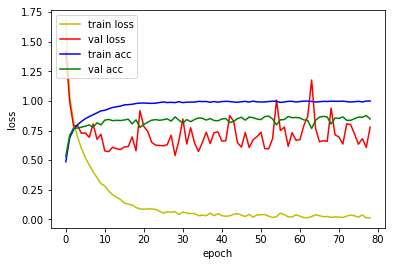

4815/4815 [==============================] - 5s 992us/sample - loss: 0.6660 - acc: 0.8336
Loss: 0.6659552693738373 Accuracy: 0.83364487

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5492 - acc: 0.5335
Epoch 00001: val_loss improved from inf to 1.26278, saving model to model/checkpoint/1D_CNN_custom_3_BN_7_conv_checkpoint/001-1.2628.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 1.5494 - acc: 0.5334 - val_loss: 1.2628 - val_acc: 0.6052
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8123 - acc: 0.7654
Epoch 00002: val_loss improved from 1.26278 to 0.69695, saving model to model/checkpoint/1D_CNN_custom_3_BN_7_conv_checkpoint/002-0.6969.hdf5
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.8125 - acc: 0.7653 - val_loss: 0.6969 - val_acc: 0.8025
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5872 - a

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0352 - acc: 0.9923
Epoch 00027: val_loss improved from 0.27991 to 0.27921, saving model to model/checkpoint/1D_CNN_custom_3_BN_7_conv_checkpoint/027-0.2792.hdf5
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0352 - acc: 0.9923 - val_loss: 0.2792 - val_acc: 0.9283
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9954
Epoch 00028: val_loss improved from 0.27921 to 0.27402, saving model to model/checkpoint/1D_CNN_custom_3_BN_7_conv_checkpoint/028-0.2740.hdf5
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0254 - acc: 0.9954 - val_loss: 0.2740 - val_acc: 0.9299
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9942
Epoch 00029: val_loss did not improve from 0.27402
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0278 - acc: 0.9941 - val_loss: 0.3239 - val_ac

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0129 - acc: 0.9974
Epoch 00056: val_loss did not improve from 0.26672
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0130 - acc: 0.9974 - val_loss: 0.2911 - val_acc: 0.9336
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0199 - acc: 0.9948
Epoch 00057: val_loss did not improve from 0.26672
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0199 - acc: 0.9948 - val_loss: 0.2748 - val_acc: 0.9352
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0065 - acc: 0.9990
Epoch 00058: val_loss did not improve from 0.26672
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0066 - acc: 0.9990 - val_loss: 0.3062 - val_acc: 0.9292
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9923
Epoch 00059: val_loss did not improve from 0.26672
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0050 - acc: 0.9993
Epoch 00085: val_loss did not improve from 0.25585
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0050 - acc: 0.9993 - val_loss: 0.2862 - val_acc: 0.9399
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0112 - acc: 0.9972
Epoch 00086: val_loss did not improve from 0.25585
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0113 - acc: 0.9972 - val_loss: 0.3116 - val_acc: 0.9327
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0178 - acc: 0.9951
Epoch 00087: val_loss did not improve from 0.25585
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0178 - acc: 0.9951 - val_loss: 0.2898 - val_acc: 0.9390
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0041 - acc: 0.9994
Epoch 00088: val_loss did not improve from 0.25585
36805/36805 [========================

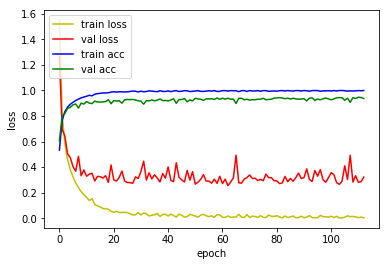

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3075 - acc: 0.9259
Loss: 0.3074763776527511 Accuracy: 0.9258567

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2694 - acc: 0.6167
Epoch 00001: val_loss improved from inf to 0.93888, saving model to model/checkpoint/1D_CNN_custom_3_BN_8_conv_checkpoint/001-0.9389.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 1.2694 - acc: 0.6167 - val_loss: 0.9389 - val_acc: 0.7310
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5333 - acc: 0.8477
Epoch 00002: val_loss improved from 0.93888 to 0.44495, saving model to model/checkpoint/1D_CNN_custom_3_BN_8_conv_checkpoint/002-0.4450.hdf5
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.5335 - acc: 0.8477 - val_loss: 0.4450 - val_acc: 0.8754
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3635 - acc:

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0384 - acc: 0.9890
Epoch 00027: val_loss did not improve from 0.16309
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0384 - acc: 0.9890 - val_loss: 0.1782 - val_acc: 0.9495
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0137 - acc: 0.9976
Epoch 00028: val_loss did not improve from 0.16309
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0139 - acc: 0.9975 - val_loss: 0.1748 - val_acc: 0.9525
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0250 - acc: 0.9935
Epoch 00029: val_loss did not improve from 0.16309
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0250 - acc: 0.9935 - val_loss: 0.1704 - val_acc: 0.9553
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9982
Epoch 00030: val_loss did not improve from 0.16309
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9986
Epoch 00056: val_loss did not improve from 0.14779
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0075 - acc: 0.9986 - val_loss: 0.1496 - val_acc: 0.9611
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9996
Epoch 00057: val_loss did not improve from 0.14779
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0027 - acc: 0.9996 - val_loss: 0.1688 - val_acc: 0.9571
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0177 - acc: 0.9954
Epoch 00058: val_loss did not improve from 0.14779
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0177 - acc: 0.9954 - val_loss: 0.1779 - val_acc: 0.9555
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9994
Epoch 00059: val_loss did not improve from 0.14779
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.9993
Epoch 00085: val_loss did not improve from 0.14726
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0033 - acc: 0.9993 - val_loss: 0.2029 - val_acc: 0.9522
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9970
Epoch 00086: val_loss did not improve from 0.14726
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0111 - acc: 0.9970 - val_loss: 0.2875 - val_acc: 0.9394
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9970
Epoch 00087: val_loss did not improve from 0.14726
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0113 - acc: 0.9970 - val_loss: 0.1810 - val_acc: 0.9564
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0043 - acc: 0.9990
Epoch 00088: val_loss did not improve from 0.14726
36805/36805 [========================

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.9996
Epoch 00115: val_loss did not improve from 0.14726
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0021 - acc: 0.9996 - val_loss: 0.1806 - val_acc: 0.9604
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0064 - acc: 0.9982
Epoch 00116: val_loss did not improve from 0.14726
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0064 - acc: 0.9982 - val_loss: 0.1678 - val_acc: 0.9634
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0050 - acc: 0.9988
Epoch 00117: val_loss did not improve from 0.14726
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0050 - acc: 0.9988 - val_loss: 0.1927 - val_acc: 0.9599
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.9996
Epoch 00118: val_loss did not improve from 0.14726
36805/36805 [=======

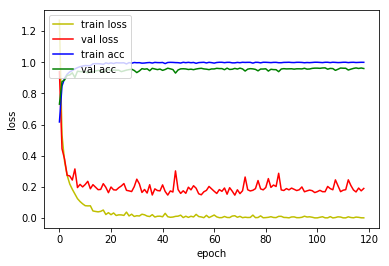

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2016 - acc: 0.9504
Loss: 0.2015724228704706 Accuracy: 0.95036346

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9442 - acc: 0.7083
Epoch 00001: val_loss improved from inf to 0.62360, saving model to model/checkpoint/1D_CNN_custom_3_BN_9_conv_checkpoint/001-0.6236.hdf5
36805/36805 [==============================] - 115s 3ms/sample - loss: 0.9441 - acc: 0.7084 - val_loss: 0.6236 - val_acc: 0.8321
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3586 - acc: 0.8911
Epoch 00002: val_loss improved from 0.62360 to 0.33616, saving model to model/checkpoint/1D_CNN_custom_3_BN_9_conv_checkpoint/002-0.3362.hdf5
36805/36805 [==============================] - 97s 3ms/sample - loss: 0.3587 - acc: 0.8910 - val_loss: 0.3362 - val_acc: 0.8921
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2503 - acc

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0137 - acc: 0.9968
Epoch 00027: val_loss did not improve from 0.14394
36805/36805 [==============================] - 97s 3ms/sample - loss: 0.0137 - acc: 0.9968 - val_loss: 0.2691 - val_acc: 0.9299
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0245 - acc: 0.9931
Epoch 00028: val_loss did not improve from 0.14394
36805/36805 [==============================] - 97s 3ms/sample - loss: 0.0245 - acc: 0.9931 - val_loss: 0.1849 - val_acc: 0.9520
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9985
Epoch 00029: val_loss improved from 0.14394 to 0.14176, saving model to model/checkpoint/1D_CNN_custom_3_BN_9_conv_checkpoint/029-0.1418.hdf5
36805/36805 [==============================] - 97s 3ms/sample - loss: 0.0076 - acc: 0.9985 - val_loss: 0.1418 - val_acc: 0.9637
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.006

36800/36805 [============================>.] - ETA: 0s - loss: 0.0068 - acc: 0.9983
Epoch 00056: val_loss did not improve from 0.12473
36805/36805 [==============================] - 97s 3ms/sample - loss: 0.0068 - acc: 0.9983 - val_loss: 0.1691 - val_acc: 0.9588
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0069 - acc: 0.9982
Epoch 00057: val_loss did not improve from 0.12473
36805/36805 [==============================] - 97s 3ms/sample - loss: 0.0069 - acc: 0.9982 - val_loss: 0.1405 - val_acc: 0.9653
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.9996
Epoch 00058: val_loss did not improve from 0.12473
36805/36805 [==============================] - 97s 3ms/sample - loss: 0.0020 - acc: 0.9996 - val_loss: 0.1505 - val_acc: 0.9646
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0098 - acc: 0.9973
Epoch 00059: val_loss did not improve from 0.12473
36805/36805 [========================

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0147 - acc: 0.9961
Epoch 00086: val_loss did not improve from 0.12473
36805/36805 [==============================] - 97s 3ms/sample - loss: 0.0147 - acc: 0.9961 - val_loss: 0.1387 - val_acc: 0.9672
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.9995
Epoch 00087: val_loss did not improve from 0.12473
36805/36805 [==============================] - 97s 3ms/sample - loss: 0.0020 - acc: 0.9995 - val_loss: 0.1408 - val_acc: 0.9665
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0013 - acc: 0.9997
Epoch 00088: val_loss did not improve from 0.12473
36805/36805 [==============================] - 97s 3ms/sample - loss: 0.0016 - acc: 0.9997 - val_loss: 0.1445 - val_acc: 0.9660
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0080 - acc: 0.9978
Epoch 00089: val_loss did not improve from 0.12473
36805/36805 [===========

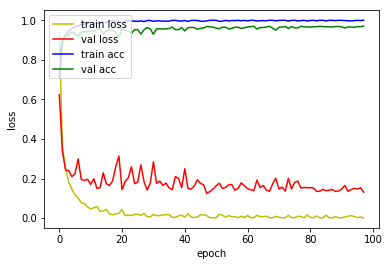

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1868 - acc: 0.9551
Loss: 0.18683712394561847 Accuracy: 0.9551402



In [10]:
for i in range(4, 10):
    base = '1D_CNN_custom_3_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_3_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_3_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 6

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.6660 - acc: 0.8336
Loss: 0.6659552693738373 Accuracy: 0.83364487

1D_CNN_custom_3_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_61 (Activation)   (None, 16000

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2016 - acc: 0.9504
Loss: 0.2015724228704706 Accuracy: 0.95036346

1D_CNN_custom_3_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_76 (Activation)   (None, 16000

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_3_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 6

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.9339 - acc: 0.8260
Loss: 0.9338605107300502 Accuracy: 0.8259605

1D_CNN_custom_3_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_61 (Activation)   (None, 16000,

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2214 - acc: 0.9526
Loss: 0.22138694069509782 Accuracy: 0.952648

1D_CNN_custom_3_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_76 (Activation)   (None, 16000,